# COMM061 - Natural Language Processing Coursework -  Group Deployment

## Netflix Shows and Movies Genre Classification

Danylo Kovalenko 
URN: **6413526**<br>
Jamie Dance 
URN: **6661320**<br>
Prakash Jha 
URN: **6659329**

### ----------------------------------------------------------------------------------------------------------------------------------


## Table of Contents

* [Introduction](#intro)
* [Model Serving Options](#model_serving)
* [Importing Libraries and Loading the Dataset](#imports)
* [Preparing the Dataset](#preparation)
* [Description Processing and the SVM model](#further_processing)
* [CI/ID Pipeline](#pipelining)
* [Testing](#testing)
* [The Performance of the Service - the Good and Bad Points](#performance)

<a class="anchor" id="intro"></a>

## Introduction

Method used: 
* Break down the genres column into separate columns 
* Remove underrepresented genres and bucket them into 'Other'
* Obtain a list of stopwords from the NLTK and sklearn libraries
* Prepare the descriptions - make lowercase, remove punctuation, fix contractions, remove numeric characters, remove stopwords 
* Apply keras tokeniser and Snowball Stemmer
* Vectorise (with n-grams)
* Build the SVM model
* Create a pipeline


Having completed the individual experimentation, we concluded that the best model to use with this dataset is the LSTM neural network, as it was giving the highest AUC ROC score. However, the purpose of this task is to successfully deploy a model. After numerous attempts to create a pipeline and deploy the LSTM model, we decided to switch to the SVM model. Although its ROC AUC score is not as high, it is reasonable for the purposes of the task. Furthermore, it is a much faster model, which may be preferred by the end user. 

The following code first loads and prepares the dataset, then builds the SVM model and then creates the pipeline. 

<a class="anchor" id="model_serving"></a>

## Model Serving Option(s) and the Right Choice for Us 

The most common way to deploy a trained model is to save into the binary format of the tool of your choice, wrap it in a microservice (such as Python's Flask application) and use it for inference. As argued by Javier Ramos (itnext.io, 2020), managed solutions simplify this deployment process and provide tools to perform canary releases and A/B testing. This approach is known as **"Model as Code"**. However, this approach has several disadvantages, as the number of models grow, the number of microservices multiplies and so do the number of failure points, latency, etc…. Making it potentially very difficult to manage.
Another method and more recent approach is to standardize the model format so it can be used programmatically using any programming language so you don’t have to wrap it in a microservice. This is specially useful for data processing streams where latency and error management is an issue. Since we call the model directly we don’t have to worry about monitoring, error handling, etc. This approach is known as **“Model as Data”**.

**Model as Code**

This is the most common method of deployment due to the process being significantly simpler to use for model developers that are not skilled in software engineering. This method allows them to use their skills in tools such as Python, R, Jupyter Notebook, etc, to train models and use their existing knowledge, usually Python to wrap the models in HTTP services. 
Some of the tools that focus on model serving are:
* Flask
* Seldon
* Clipper
* TensorFlow Serving

The advantages of this approach are:
* Easy to develop.
* Developers do not ned to care about production maintenance and monitoring. Site reliability engineering can manage these services.
* Can be automated using tools such as AWS SageMaker.

The disadvantages of this approach are:
* The complexity to monitor and maintain the models grow as more and more models are added.
* Extra latency and more points of failures which affect reliability.
* Impedance Mismatch: Model developers or data scientists use a different set of tools such R or Python compared to Software developers.
* Difficult to update the model.
* It does not scale for big data streaming pipelines due to extra latency and data size.

**Model as Data** 

A more recent approach is to standardize the models as data so it can be read in any programming language. Currently, Tensorflow has emerged as the go to application, the new SavedModel format contains a complete TensorFlow program, including weights and computation. It does not require the original model building code to run, which makes it useful for sharing.
Solutions can be implements using solutions such as:
* Akka Streams
* Spark Structured Streaming
* Flink

The advantages of using this approach are:
* Simplified model management.
* Model standardization.
* Low latency.
* Easier to implement, many options available.
* Helps with communication when you have silos.

The disadvantages of using this approach are:
* Not all Data Scientist tools support the current standard formats. For certain use cases you just can’t use this approach yet.
* Early stages of standardization.


**Our direction**

Due to the simplicity and the need for an easy to develop solution we have decided to use the traditional Flask model serving option. It is quick and easy to build a minimal but powerful platform. All members of the group have experience with Flask prior to this assessment so naturally it seemed like the logical method to go with so that we could provide the best possible solution. Given more time maybe we could have tested some of the more modern solutions as specified in previous sections.


<a class="anchor" id="imports"></a>

## Importing Libraries and Loading the Dataset 

The first step is to import some common libraries and to load the dataset. The dataset is a csv file, so it is loaded as a dataframe using pandas.

In [52]:
# reading and manipulating the dataset
import pandas as pd
import numpy as np
import re
import contractions

# visualisations
from matplotlib import pyplot as plt
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# typing annotations
from typing import List

# NLP libraries
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from keras.preprocessing.text import text_to_word_sequence

# train/test splitting
from sklearn.model_selection import train_test_split

# machine learning models
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# scoring
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from joblib import dump, load

# miscellaneous libraries
from collections import Counter 
from collections import defaultdict
from statistics import median

In [53]:
# read the file
netflix = pd.read_csv('netflix_titles.csv')

<a class="anchor" id="preparation"></a>

## Preparing the Dataset

Same steps are followed as during our individual experimentations. Please refer to those files for any explanations of the approach. 

In [54]:
# drop irrelevant columns
netflix = netflix[['listed_in', 'description']]

# rename "listed_in"
netflix.rename(columns={'listed_in' : 'genre'}, inplace=True)

# split the genres, change to lowercase
for index in netflix.index:
    netflix['genre'][index] = netflix['genre'][index].lower().split(", ")

# create a list of possible genres and check how many there are
genres = set()

for index in netflix.index:
    for i in (netflix['genre'][index]):
        genres.add(i)

print(f" There are {len(genres)} unique genres in total\n")
print(genres)

# count the number of occurances for each genre
total_genres = [i for index in netflix.index for i in netflix['genre'][index]]
genre_count = Counter(total_genres)

# calculate the median number of occurances
med = median(genre_count.values())
print("The median number of genre occurance is:", med)

# create a default dictionary
category_count = defaultdict(int)
for i in netflix.genre: 
    category_count[len(i)] += 1

print(f"The maximum number of categories per title: {max(category_count)}")
print(f"The minimum number of categories per title: {min(category_count)}\n")

for num, freq in category_count.items(): 
    print(f"The number of titles attributed to *{num}* genres is: {freq}")
    
# create a column for each genre 
for i in genres: 
    netflix[i] = 0 

# if a title belongs to a genre, give a corresponding entry in a column a value of 1
for index in netflix.index:
    for genre in netflix.genre[index]:
        netflix.loc[index, genre] = 1 

# set a boundary 
threshold = med

# create a list of genres out of the *genre_count* counter keys that have fewer occurances than the threshold
# underrep = [i for i in netflix if i != 'description' and i != 'genre' and netflix[i].sum() < threshold]
underrep = [key for key, value in genre_count.items() if value < threshold]

# create a column "other"
netflix['other'] = 0

# give "other" a value of 1 when a title belongs to a rare genre
for index, row in netflix[underrep].iterrows():
    if row.sum() > 0:
        netflix.loc[index, 'other'] = 1

# drop underrepresented genres from the dataframe
netflix = netflix.drop(underrep, axis=1)

 There are 42 unique genres in total

{'teen tv shows', 'sci-fi & fantasy', 'cult movies', 'anime series', 'docuseries', 'lgbtq movies', 'crime tv shows', 'international movies', 'independent movies', 'tv dramas', 'tv shows', 'tv mysteries', 'thrillers', 'stand-up comedy & talk shows', 'romantic movies', 'british tv shows', 'music & musicals', 'science & nature tv', 'classic movies', 'spanish-language tv shows', 'international tv shows', 'reality tv', 'tv horror', 'tv thrillers', 'sports movies', 'tv sci-fi & fantasy', 'horror movies', 'tv action & adventure', 'anime features', 'dramas', 'tv comedies', 'romantic tv shows', 'korean tv shows', 'children & family movies', 'faith & spirituality', 'documentaries', 'comedies', 'stand-up comedy', 'movies', 'classic & cult tv', "kids' tv", 'action & adventure'}
The median number of genre occurance is: 220.0
The maximum number of categories per title: 3
The minimum number of categories per title: 1

The number of titles attributed to *3* genres

<a class="anchor" id="further_processing"></a>

## Description Processing and the SVM model

The following code cleans up all descriptions and prepares them to be fed into the SVM model. The SVM model is then trained. 

**\* Please note that running this code is not necessary for creating the pipeline.**

In [55]:
# install the package required to remove any contractions
# !pip install contractions

Create a copy of the dataset so that it is separate from pipelining. 

In [56]:
# create a copy of the dataset
netflix_base = netflix.copy()

In [57]:
def lowercase(text: str) -> str:
    """Changes *text* to lowercase"""
    text = text.lower()
    return text

assert lowercase("Test") == "test"

def remove_punct(text: str) -> str: 
    """Removes any punctuation"""
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('[,\.!?]', '', text)
    return text

assert remove_punct("t:est'.") == "test"

def remove_numeric(text: str) -> str: 
    """Removes any numbers"""
    text = re.sub('[^a-z A-Z]+', '', text)
    return text

assert remove_numeric("test1") == "test"

def expand_contractions(text: str) -> str: 
    """Expands any common English language contractions"""
    text = contractions.fix(text)
    return text

assert expand_contractions("we'd") == "we would"

def clean_descr(text: str) -> str: 
    text = lowercase(text)
    text = expand_contractions(text)
    text = remove_punct(text)
    text = remove_numeric(text)
    return text

assert clean_descr("te:'st'. we'd Love to1 pa2:ss") == "test we would love to pass"

In [58]:
# clean all descriptions
netflix_base['description'] = netflix_base['description'].map(clean_descr)

In [59]:
# tokenise
netflix_base['description'] = netflix_base['description'].map(lambda x: text_to_word_sequence(x))
tokens = netflix_base.description.tolist()

In [60]:
# obtain a list of English stopwords provided in nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# obtain a list of English stopwords provided in sklearn
stop_words_sklearn = ENGLISH_STOP_WORDS

# combine two lists of stopwords
for word in stop_words_sklearn:
    if word not in stop_words:
        stop_words.append(word)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
def remove_stopwords(text: List[str], stopwords: List[str]) -> List[str]: 
    """Removes any stopwords present in *stopwords*"""
    text = [word for word in text if word not in stopwords]
    return text

assert remove_stopwords(["earthquake", "me"], stop_words) == ["earthquake"]

In [62]:
# remove stopwords
netflix_base['description'] = netflix_base['description'].map(lambda x: remove_stopwords(x, stop_words))

In [63]:
# drop the 'genre' column
netflix_base = netflix_base.drop(columns=['genre'])

In [64]:
# import Snowball stemmer
stemmer = SnowballStemmer("english")

# apply stemming to each tokenised description
netflix_base.description = [[stemmer.stem(token) for token in description] for description in netflix_base.description]

In [65]:
threshold = 3

# remove tokens that have fewer than 3 characters 
netflix_base.description = [[token for token in description if len(token) > threshold] for description in netflix_base.description]

# print shape of each copy before and after and remove any rows where description is below the threshold
for index in netflix_base.index:
        if len(netflix_base.description[index]) <= threshold: 
            netflix_base = netflix_base.drop([index])

In [66]:
# define X and y for spacy_spalem
X = netflix_base.description
X = [" ".join(t) for t in X]
y = netflix_base.drop('description', axis=1)

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

In [67]:
# define the vectoriser and create n-grams.
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), max_features=1000)

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [68]:
# apply the SVC model and print out different performance metrics
svc_clf = OneVsRestClassifier(SVC(C=10, gamma='scale', kernel='rbf', max_iter=500)).fit(X_train, y_train)

prediction_train = svc_clf.predict(X_train)
prediction_test = svc_clf.predict(X_test)

<a class="anchor" id="pipelining"></a>

## CI/CD Pipeline

The code below prepares the dataset to be used with the pipeline. We define the stopwords which will be removed in the pipeline. 

In [69]:
# obtain a list of English stopwords provided in nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# obtain a list of English stopwords provided in sklearn
stop_words_sklearn = ENGLISH_STOP_WORDS

# combine two lists of stopwords
for word in stop_words_sklearn:
    if word not in stop_words:
        stop_words.append(word)
print("Final number of stopwords:", len(stop_words))

Final number of stopwords: 378


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The 'genre' column, which is now redundant, should be dropped. Then, we can define the X and y values.

In [70]:
# drop the 'genre' column
netflix = netflix.drop(columns=['genre'])

In [71]:
X = netflix.description
y = netflix.drop('description', axis=1)

The dataset can be split into train and test subsets so that the model performance can be evaluated using the unseen data. The split is 20% test 80% train data.  

In [72]:
# split into trainval/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

Test values can now be saved into separate csv files in order to be used by the endpoint. 

In [73]:
# save test data to a csv file
X_test.to_csv("test_X.csv", index=False)
y_test.to_csv("test_y.csv", index=False)

We can now build a pipeline. It consists of two parts. The first one is the vectoriser, which creates n-grams, limits the number of features to 1000 and removes any stopwords taken from the combined English stopwords from nltk and sklearn libraries. The second part is the actual model, which was tuned during the individual experimentation.

In [74]:
# create a pipeline
pipeline = Pipeline( steps = [('tfidf', TfidfVectorizer(analyzer='word', 
                                                        ngram_range=(1,3), 
                                                        max_features=1000,
                                                        stop_words=stop_words,
                                                        lowercase=True,
                                                        strip_accents='unicode')),
                              ('model', OneVsRestClassifier(SVC(C=10, gamma='scale', kernel='rbf', max_iter=500)))
                              ])

We can now fit the pipeline and make predictions. The ROC AUC score can be used to evaluate its performance on the test data.

In [75]:
# fit the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 3),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode')),
                ('model',
                 OneVsRestClassifier(estimator=SVC(C=10, max_iter=500)))])

In [76]:
# use pipeline to predict X_train
pipe_train = pipeline.predict(X_train)
pipe_train

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 1]])

In [77]:
# use pipeline to predict X_test
pipe_test = pipeline.predict(X_test)
pipe_test 

array([[0, 0, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [78]:
# calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, pipeline.predict(X_test))
roc_auc

0.6001871423664922

Before deploying the model, we can test whether the pipeline works predictably with the previously created csv files for test subsets. To do this, we load the files and recalculate the ROC AUC score.

In [79]:
# load the files
X_test = pd.read_csv("test_X.csv").description
y_test = pd.read_csv("test_y.csv")

In [80]:
# calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, pipeline.predict(X_test))
roc_auc

0.6001871423664922

In [81]:
f1_samples = f1_score(y_true=y_test, y_pred= pipeline.predict(X_test), average='samples')
f1_samples

0.31938493684321667

We can now save the pipeline to be used in the deployment.

In [82]:
# save the pipeline
dump(pipeline, filename="genre_classification.joblib")

['genre_classification.joblib']

It is now important to test the model by loading the pipeline and checking whether it produces some output with some  user text. Text is first converted into the pandas.Series format and then a prediction is made. 

In [83]:
pipeline = load("genre_classification.joblib")

In [84]:
text = pd.Series("Dangerous criminal is on the run again")

In [85]:
test = pipeline.predict(text)
test

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

Confusion matrices can also be produced using the pipeline predictions in order to see the performance for each genre.

In [86]:
# taken and adapted from 
# https://stackoverflow.com/questions/62722416/plot-confusion-matrix-for-multilabel-classifcation-python
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes, cmap='rocket_r')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

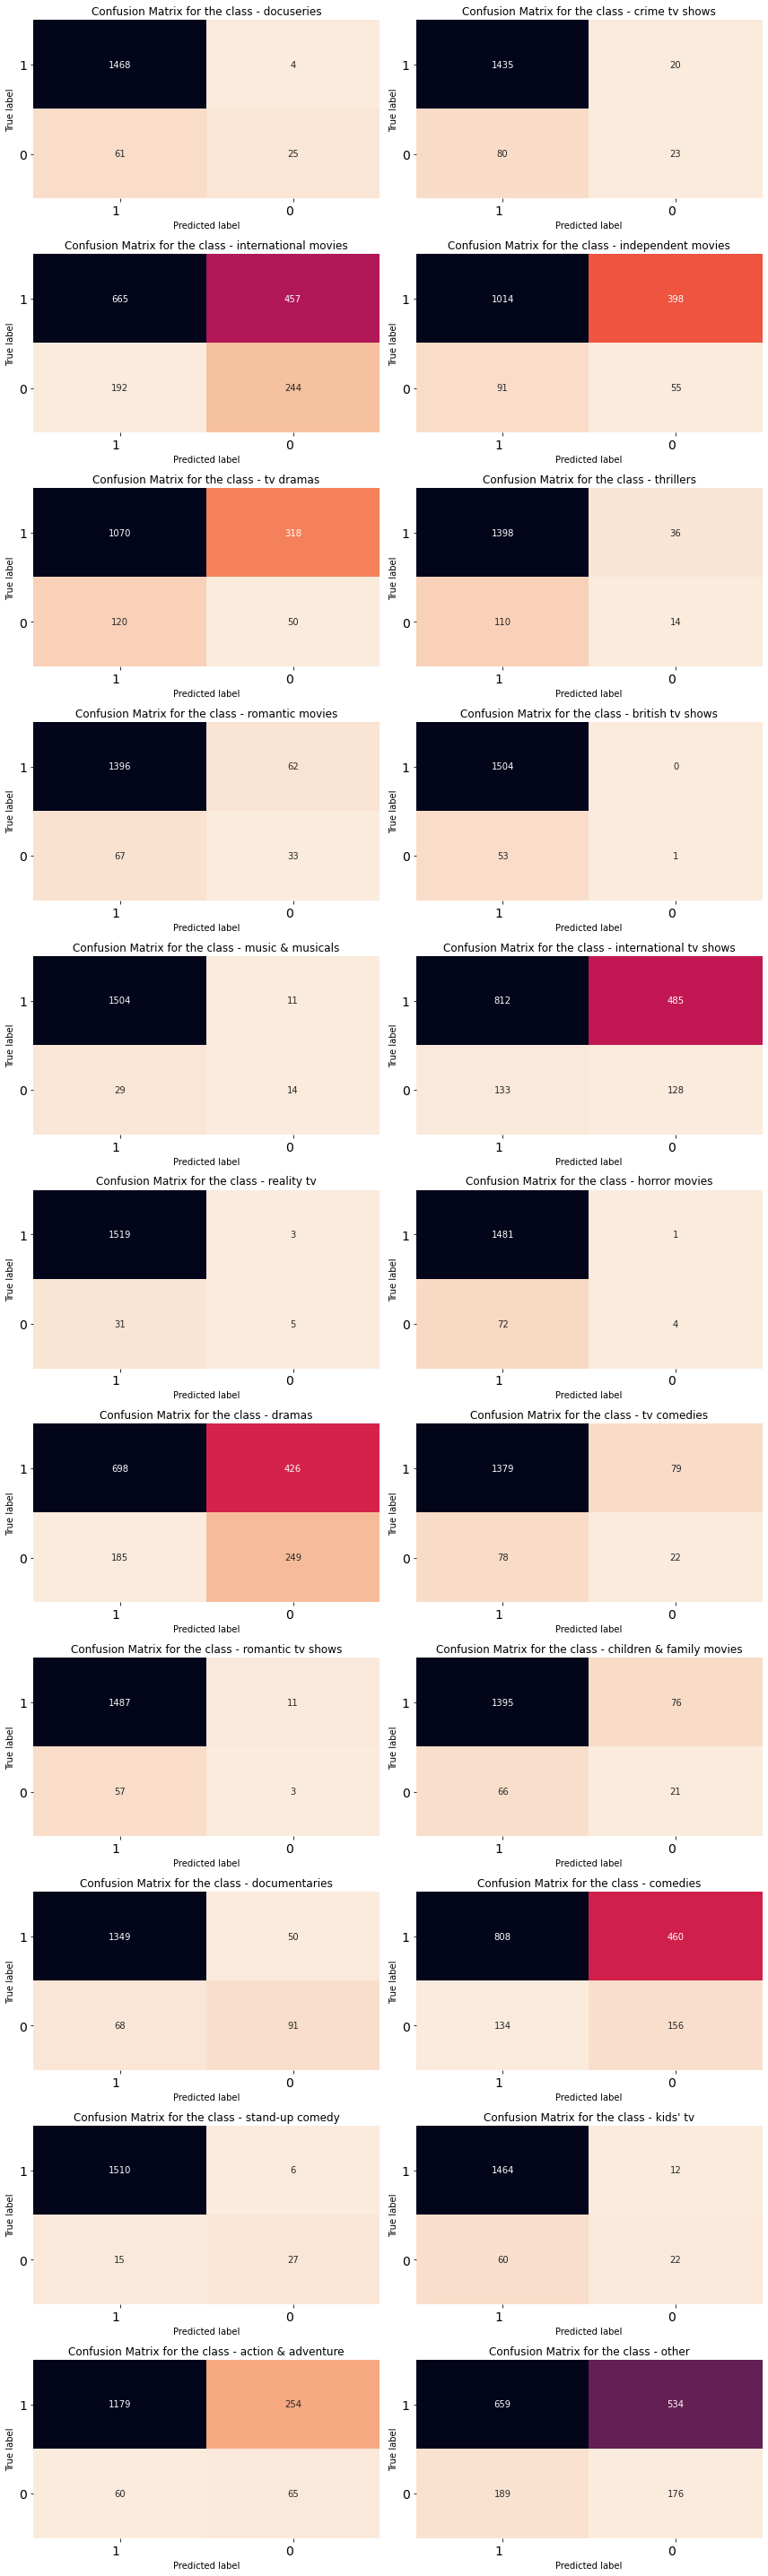

In [87]:
# taken and adapted from 
# https://stackoverflow.com/questions/62722416/plot-confusion-matrix-for-multilabel-classifcation-python

matrix_svc = multilabel_confusion_matrix(y_true=y_test, y_pred=pipeline.predict(X_test))
labels = y_test.columns

fig, ax = plt.subplots(11, 2, figsize=(12, 40))
    
for axes, cfs_matrix, label in zip(ax.flatten(), matrix_svc, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["1", "0"])
    
fig.tight_layout()

fig.savefig('confusion_plots.png')
plt.show()

The following line will run the classification.py file, which can be viewed locally.

In [88]:
# !python classification.py

A more sophisticated pipeline can also be built. It has an additional part - the preprocessing, which is manually defined. The following function defines the preprocessing steps. It is then passed into FunctionTransformer to be used with the pipeline. 

This method gives a slightly higher ROC AUC score. It also ensures that any input passed by the user is first normalised and cleaned, and only then passed to the model. However, when trying to deploy it, we were running into an Attribute error. Hence, our classification.py has some error handling to try to use the following pipeline and use the one before if the try is unsucessful. 

In [89]:
def preprocessing(X) -> List[str]:
    
    from sklearn.preprocessing import FunctionTransformer
    
    def lowercase(text: str) -> str:
        """Changes *text* to lowercase"""
        text = text.lower()
        return text

    def remove_punct(text: str) -> str: 
        """Removes any punctuation"""
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub('[,\.!?]', '', text)
        return text

    def remove_numeric(text: str) -> str: 
        """Removes any numbers"""
        text = re.sub('[^a-z A-Z]+', '', text)
        return text

    def expand_contractions(text: str) -> str: 
        """Expands any common English language contractions"""
        text = contractions.fix(text)
        return text

    def clean_descr(text: str) -> str: 
        text = lowercase(text)
        text = expand_contractions(text)
        text = remove_punct(text)
        text = remove_numeric(text)
        return text
    
    def remove_stopwords(text: List[str], stopwords: List[str]) -> List[str]: 
        """Removes any stopwords present in *stopwords*"""
        text = [word for word in text if word not in stopwords]
        return text
    
    global stop_words
    
    X = X.map(clean_descr)
    X = X.map(lambda x: text_to_word_sequence(x))
    X = X.map(lambda x: remove_stopwords(x, stop_words))
    
    stemmer = SnowballStemmer("english")

    X = [[stemmer.stem(token) for token in description] for description in X]
    X = [" ".join(t) for t in X]
    return X

In [90]:
pipeline1 = Pipeline( steps = [('preprocess', FunctionTransformer(preprocessing)),
                              ('tfidf', TfidfVectorizer(analyzer='word', 
                                                        ngram_range=(1,3), 
                                                        max_features=1000,
                                                        stop_words=stop_words,
                                                        lowercase=True,
                                                        strip_accents='unicode')),
                              ('model', OneVsRestClassifier(SVC(C=10, gamma='scale', kernel='rbf', max_iter=500)))
                              ])

In [91]:
# fit the pipeline
pipeline1.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 FunctionTransformer(func=<function preprocessing at 0x7fc1cda8c670>)),
                ('tfidf',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 3),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode')),
                ('model',
                 OneVsRestClassifier(estimator=SVC(C=10, max_iter=500)))])

In [92]:
# use pipeline to predict X_train
pipe1_train = pipeline1.predict(X_train)
pipe1_train

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 1]])

In [93]:
# use pipeline to predict X_test
pipe1_test = pipeline1.predict(X_test)
pipe1_test 

array([[0, 0, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 1, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [94]:
# calculate the ROC AUC score
roc_auc1 = roc_auc_score(y_test, pipeline1.predict(X_test))
roc_auc1

0.6108249806358041

In [95]:
f1_samples1 = f1_score(y_true=y_test, y_pred= pipeline1.predict(X_test), average='samples')
f1_samples1

0.3348401491533713

In [96]:
# save the pipeline
dump(pipeline, filename="genre_classification1.joblib")

['genre_classification1.joblib']

In [97]:
pipeline1['preprocess'].transform(text)

['danger crimin run']

<a class="anchor" id="testing"></a>

## Testing

We did our API testing with the use of 'Postman'. It  does a sort of health-check to ensure our GET and POST methods are working smoothly and the service is up and running along with the build version of an API that is being deployed. We did the unit testing on our functions through the use of 'assert' statements. Each function has an assert statement to ensure that it works and behaves in the expected manner. We have carried out multiple unit tests throughout the code, as can be seen from the code above, in order to see that each block of code produces the expected output. The logic error testing was also carried out in the end to see we are getting the appropriate output. Finally, we have performed some functional testing with different user inputs in order to see whether the whole system works.

<a class="anchor" id="performance"></a>

## The Performance of the Service - the Good and Bad Points

Overall, we are happy with the performance of our service for the problem of classifying the genre of piece of text or description. The service is extremely quick and easy to understand as shown by the simplistic yet clear web page design. New descriptions inputted into the system are labelled on average in 500ms, this clearly shows that the system is very quick and effective. In addition, the service has no limitation to what variation of text can inputted into the system. Clearly the model is trained on movie descriptions so it is expected that it would best predict other movie descriptions. 

On the other hand, there is large amount of room for improvement, as the service is very limited in other ways. Currently the model is limited to a singular description. That means that if the user wanted to employ the service to identify multiple different descriptions at once they would be required to input them one by one. Naturally this is an extremely time-consuming process. Furthermore, the accuracy of the service’s model isn’t exceptionally high at roughly 60-61% ROC AUC score, depending on the pipeline used. The F1 score is only 31% when tested using the test dataset. This could create misleading/incorrect results when inputting new movie descriptions. Currently the output only contains a matrix format of all genres included in the analysis. This isn’t ideal as users would prefer that a list of genres was outputted instead of looking manually at a matrix. This isn’t a particular big problem, but it is definitely something that could be looked to be improved in the future. Lastly, the model is currently limited to the English Language and could not be used to label descriptions in a different language. This could be solved by invoking some sort of translator into the system that converts the language to English.

<a class="anchor" id="references"></a>

## References

1. Ramos, J., 2020. Machine Learning Model Serving Options. [online] Medium. Available at: <https://itnext.io/machine-learning-model-serving-options-1edf790d917> [Accessed 26 May 2021].